# ResNet

## Objectives

**Solve the Vanishing Gradient Problem**: ResNet introduces shortcut connections that create residual blocks, allowing gradients to flow directly through the network

**Enable Very Deep Networks**: The architecture is designed to support extremely deep networks without suffering from degradation problems

**Improve training efficiency**: The use of residual connections simplifies the training process and accelerates convergence

## Architecture
This is an example of a ResNet-50:

- **Conv1**: 7x7 convolution, 64 filters, stride 2
- **Max Pooling**: 3x3, stride 2
- **Conv2_x**: 3 bottleneck blocks, 256 filters
- **Conv3_x**: 4 bottleneck blocks, 512 filters
- **Conv4_x**: 6 bottleneck blocks, 1024 filters
- **Conv5_x**: 3 bottleneck blocks, 2048 filters
- **Average Pooling**: Global pooling
- **Fully Connected Layer**: Outputs the final class probabilities

## When to use it:

- When you need to train **very deep** networks
- When you are working on standard **image classification**, object detection, or segmentation tasks
- When you require a reliable architecture for **transfer learning** or general-purpose usage

## When not to use it:

- When computational resources are very limited
- When the application requires real-time processing
- Model size and memory footprint are major concerns

### Libraries

In [ ]:
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

### Creating Residual Blocks for ResNet

In [ ]:
class Residual(nn.Module):
  def __init__(self, num_channels, use_1x1conv=False, strides=1):
    super().__init__()
    self.conv1 = nn.LazyConv2d(num_channels, kernel_size=3, padding=1, stride=strides)
    self.conv2 = nn.LazyConv2d(num_channels, kernel_size=3, padding=1)

    if use_1x1conv:
      self.conv3 = nn.LazyConv2d(num_channels, kernel_size=1, stride=strides)
    else:
      self.conv3 = None

    self.bn1 = nn.LazyBatchNorm2d() # bn stands for batch normalization
    self.bn2 = nn.LazyBatchNorm2d()

  def forward(self, X):
    Y = F.relu(self.bn1(self.conv1(X)))
    Y = self.bn2(self.conv2(Y))
    if self.conv3:
      X = self.conv3(X)
    Y += X
    return F.relu(Y)

### Testing the 1x1 convolutional layer parameter

In [ ]:
block = Residual(num_channels=3)
X = torch.randn(4, 3, 6, 6) # same shape as output
print(f"No 1x1 conv layer: {block(X).shape}") # no need to change the input size

block = Residual(num_channels=6, use_1x1conv=True, strides=2) # different shape from the output
print(f"With 1x1 conv layer: {block(X).shape}\n") # change in the input size

No 1x1 conv layer: torch.Size([4, 3, 6, 6])
With 1x1 conv layer: torch.Size([4, 6, 3, 3])



/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


### Initialization and creation of the ResNet

In [ ]:
def init_cnn(module): # first defined in the LeNet notebook
    if (type(module) == nn.Linear or type(module) == nn.Conv2d):
        nn.init.xavier_uniform_(module.weight)

class ResNet(d2l.Classifier):
  def b1(self): # he block before the residual blocks
    return nn.Sequential( # same start as the GoogLeNet's
        nn.LazyConv2d(64, kernel_size=7, stride=2, padding=3), nn.LazyBatchNorm2d(), nn.ReLU(),
        nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
    )

  def block(self, num_residuals, num_channels, first_block=False): # returns a sequence of residual blocks in a row
    blk = []
    for i in range(num_residuals):
      if (i == 0 and not first_block):
        blk.append(Residual(num_channels, use_1x1conv=True, strides=2))
      else:
        blk.append(Residual(num_channels)) # use 1x1 conv = False
    return nn.Sequential(*blk)

  def __init__(self, arch, lr=0.1, num_classes=10):
    super(ResNet, self).__init__()
    self.save_hyperparameters()
    self.net = nn.Sequential(self.b1())
    for i, b in enumerate(arch):
      self.net.add_module(f"b{i+2}", self.block(*b, first_block=(i==0)))
    self.net.add_module("last", nn.Sequential(
        nn.AdaptiveAvgPool2d((1, 1)), nn.Flatten(),
        nn.LazyLinear(num_classes)
    ))
    self.net.apply(init_cnn)

### Evaluation of the correctness of each layer of ResNet

In [ ]:
def layer_summary(self, X_shape): # first defined in the LeNet notebook
    X = torch.randn(X_shape)
    for layer in self.net:
        X = layer(X)
        print(layer.__class__.__name__, 'output shape:\t', X.shape)

class ResNet18(ResNet): # Inheriting the ResNet class
  def __init__(self, lr=0.1, num_classes=10):
    super().__init__(((2, 64), (2, 128), (2, 256), (2, 512)), lr, num_classes)

model = ResNet18()
layer_summary(model, (1, 1, 96, 96))

Sequential output shape:	 torch.Size([1, 64, 24, 24])
Sequential output shape:	 torch.Size([1, 64, 24, 24])
Sequential output shape:	 torch.Size([1, 128, 12, 12])
Sequential output shape:	 torch.Size([1, 256, 6, 6])
Sequential output shape:	 torch.Size([1, 512, 3, 3])
Sequential output shape:	 torch.Size([1, 10])


### Training the ResNet

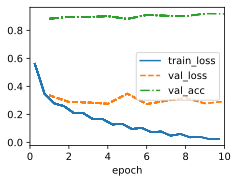

In [ ]:
model = ResNet18(lr=0.01)
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128, resize=(96, 96))
model.apply_init([next(iter(data.get_dataloader(True)))[0]], d2l.init_cnn)
trainer.fit(model, data)

# ResNeXt

## Objectives

- **Increase Model Capacity Efficiently**: ResNeXt aims to enhance the model’s capacity without significantly increasing computational complexity

- **Introduce Split-Transform-Merge Strategy**: The architecture uses the split-transform-merge strategy, where input features are split into multiple groups, each transformed separately by convolutional layers, and then merged back together

- **Reduced Computational Cost**: By using grouped convolutions, ResNeXt reduces the number of parameters and computational cost while maintaining or even improving performance compared to standard convolutions

## Architecture

An example of ResNeXt-50:
- **Conv1**: 7x7 convolution, 64 filters, stride 2
- **Max Pooling**: 3x3, stride 2
- **Conv2_x**: 3 bottleneck blocks, 256 filters, cardinality 32
- **Conv3_x**: 4 bottleneck blocks, 512 filters, cardinality 32
- **Conv4_x**: 6 bottleneck blocks, 1024 filters, cardinality 32
- **Conv5_x**: 3 bottleneck blocks, 2048 filters, cardinality 32
- **Average Pooling**: Global pooling
- **Fully Connected Layer**: Outputs the final class probabilities

## When to use it:

**High Performance Tasks**: For tasks that require high performance, such as fine-grained image recognition and large-scale image classification. ResNeXt often outperforms standard ResNet on these tasks

**Efficient Computation**: When you want a balance between model complexity and computational efficiency

**Improving Existing ResNet models**: When you are looking to enhance the performance of ResNet models without drastic changes to the architecture

## When not to use it:

**Simple Tasks**: For simple or less demanding tasks, the added complexity of ResNeXt might be unnecessary

**Low-latency Requirement**: Similar to ResNet, if the application demands real-time processing with minimal latency, even the optimized ResNeXt models might be too slow

### Creating Residual Blocks for ResNeXt

In [ ]:
class ResNeXtBlock(nn.Module):
  def __init__(self, num_channels, groups, bot_mul, use_1x1conv=False, strides=1): # groups represent the number of paths; bot_mul is a bottleneck multiplier
    bot_channels = int(round(num_channels * bot_mul)) # intermediate channels
    self.conv1 = nn.LazyConv2d(bot_channels, kernel_size=1, stride=1) # 1x1 conv layer is common to every path
    self.conv2 = nn.LazyConv2d(bot_channels, kernel_size=3, stride=strides, padding=1, groups=bot_channels//groups) # one 3x3 conv layer for each group (path)
    self.conv3 = nn.LazyConv2d(num_channels, kernel_size=1, stride=strides) # 1x1 conv layer is common to every path
    if use_1x1conv:
      self.conv4 = nn.LazyCnv2d(num_channels, kernel_size=1, stride=strides)
      self.bn4 = nn.LazyBatchNorm2d()
    else:
      self.conv4 = None

    def forward(self, X):
      Y = F.relu(self.bn1(self.conv1(X)))
      Y = F.relu(self.bn2(self.conv2(Y)))
      Y = self.bn3(self.conv3(Y))
      if self.conv4:
        X = self.bn4(self.conv4(X))
      Y += X
      return F.relu(Y)

### Its use is entirely analogous to that of the ResNetBlock used previously here